# WeatherPy
----


In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import os

# Import API key
from api_keys import api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "citiesfinal.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

636

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
def get_current_weather(city, api_key):
    
    url = "http://api.openweathermap.org/data/2.5/weather"
    payload = {
        "appid": api_key,
        "q": city
    }
    r = requests.get(url, params=payload)
    
    if r.status_code == 200:
        return r.json()
    else:
        return None

all_cities = []
for city in cities:
    result = get_current_weather(city, api_key)
    if result:
        all_cities.append(result)
df = pd.DataFrame([{
    "name": d["name"],
    "date_time": d["dt"],
    "lat": d["coord"]["lat"],
    "lon": d["coord"]["lon"],
    "temp": d["main"]["temp"],
    "temp_min": d["main"]["temp_min"],
    "temp_max": d["main"]["temp_max"],
    "humidity": d["main"]["humidity"],
    "wind_speed": d["wind"]["speed"],
    "clouds_percent": d["clouds"]["all"],
} for d in all_cities])

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [4]:
#create CSV file of raw data from OpenWeather API and store in Results Directory

In [5]:
#Create directory to store results
script_dir = os.path.dirname("")
results_dir = os.path.join(script_dir, 'Results/')
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
df.to_csv(results_dir + output_data_file)

In [6]:
df.head()

,name,date_time,lat,lon,temp,temp_min,temp_max,humidity,wind_speed,clouds_percent
0,Narsaq,1578240808,60.91,-46.05,266.15,266.15,266.15,57,3.10,75
1,Kapaa,1578240808,22.08,-159.32,296.37,295.15,297.15,83,8.70,75
2,Roald,1578240808,62.58,6.12,278.33,274.82,282.15,93,9.80,75
3,Georgetown,1578240589,6.80,-58.16,302.15,302.15,302.15,66,4.10,75
4,Bluff,1578240809,-23.58,149.07,295.41,295.41,295.41,77,3.68,34


In [7]:
weather_df = df

In [8]:
#Convert temperature data to Fahrenheit 

In [9]:
weather_df["Temp_F"] = weather_df["temp"].apply(lambda x: x*9/5-459.67)
weather_df["Temp_Min_F"] = weather_df["temp_min"].apply(lambda x: x*9/5-459.67)
weather_df["Temp_Max_F"] = weather_df["temp_max"].apply(lambda x: x*9/5-459.67)

In [10]:
#Convert Wind Speed from m/sec to MPH

In [11]:
weather_df["wind_speed_mph"] = weather_df["wind_speed"].apply(lambda x: x*2.237)

In [12]:
#Create dummy latitude colume to use as index for plot trendlines

In [13]:
weather_df["lat_dummy"] = weather_df["lat"]

In [14]:
weather_df.head()

,name,date_time,lat,lon,temp,temp_min,temp_max,humidity,wind_speed,clouds_percent,Temp_F,Temp_Min_F,Temp_Max_F,wind_speed_mph,lat_dummy
0,Narsaq,1578240808,60.91,-46.05,266.15,266.15,266.15,57,3.10,75,19.400,19.400,19.400,6.93470,60.91
1,Kapaa,1578240808,22.08,-159.32,296.37,295.15,297.15,83,8.70,75,73.796,71.600,75.200,19.46190,22.08
2,Roald,1578240808,62.58,6.12,278.33,274.82,282.15,93,9.80,75,41.324,35.006,48.200,21.92260,62.58
3,Georgetown,1578240589,6.80,-58.16,302.15,302.15,302.15,66,4.10,75,84.200,84.200,84.200,9.17170,6.80
4,Bluff,1578240809,-23.58,149.07,295.41,295.41,295.41,77,3.68,34,72.068,72.068,72.068,8.23216,-23.58


In [15]:
#Determine Date of run
date  = time.strftime("%b/%d/%Y")

### Latitude vs. Temperature Plot

In [16]:
#Fit line with polynomial of degree = 3
z = np.polyfit(x = weather_df.loc[:, "lat"], y = weather_df.loc[:,"Temp_F"], deg =3)
p = np.poly1d(z)
weather_df["trendline"] = p(weather_df.loc[:, "lat"])

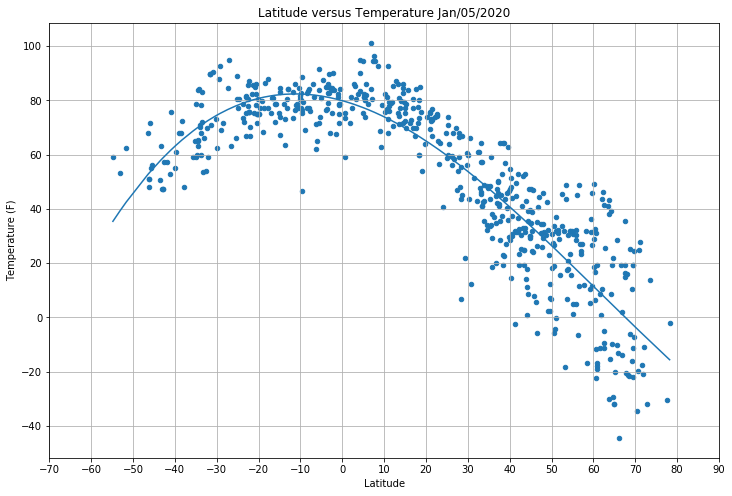

In [17]:
#Create scatterplot of Latitude vs Temperature
ax = weather_df.plot.scatter(figsize=(12,8), x="lat", y="Temp_F")
weather_df.set_index("lat_dummy", inplace = True)
weather_df.trendline.sort_index(ascending = False).plot(ax=ax)
ax.set_xlabel("Latitude", fontsize=10)
ax.set_ylabel("Temperature (F)", fontsize=10 )
ax.set_title(f"Latitude versus Temperature {date}", fontsize = 12)
ax.set_xlim([-70, 70])
plt.xticks([-70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.savefig(results_dir + "Lat_versus_Temp.png")
plt.show()

### Latitude vs. Humidity Plot

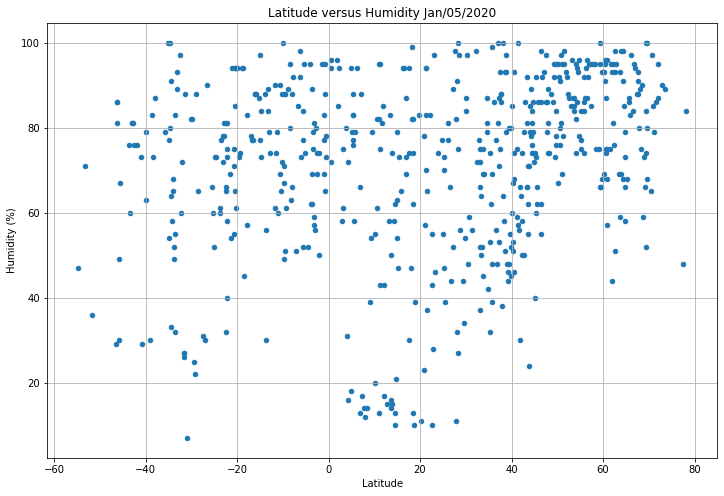

In [18]:
ax = weather_df.plot.scatter(figsize=(12,8), x="lat", y="humidity")
ax.set_xlabel("Latitude", fontsize=10)
ax.set_ylabel("Humidity (%)", fontsize=10 )
ax.set_title(f"Latitude versus Humidity {date}", fontsize = 12)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.savefig(results_dir + "Lat_versus_Humidity.png")
plt.show()

### Latitude vs. Cloudiness Plot

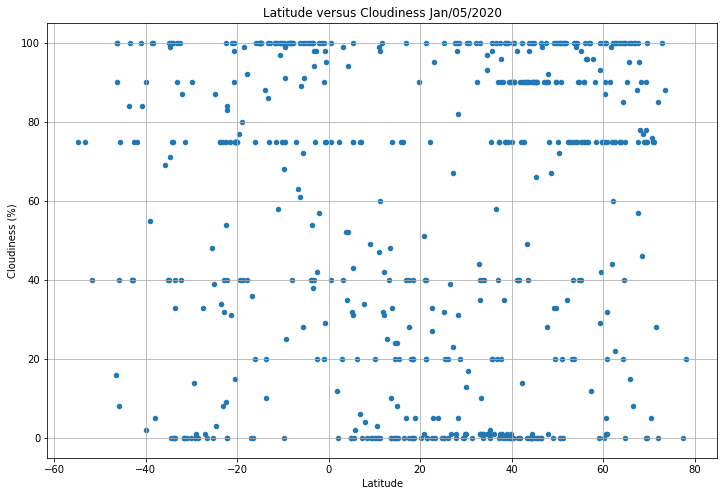

In [19]:
ax = weather_df.plot.scatter(figsize=(12,8), x="lat", y="clouds_percent")
ax.set_xlabel("Latitude", fontsize=10)
ax.set_ylabel("Cloudiness (%)", fontsize=10 )
ax.set_title(f"Latitude versus Cloudiness {date}", fontsize = 12)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.savefig(results_dir + "Lat_versus_Cloudiness.png")
plt.show()

### Latitude vs. Wind Speed Plot

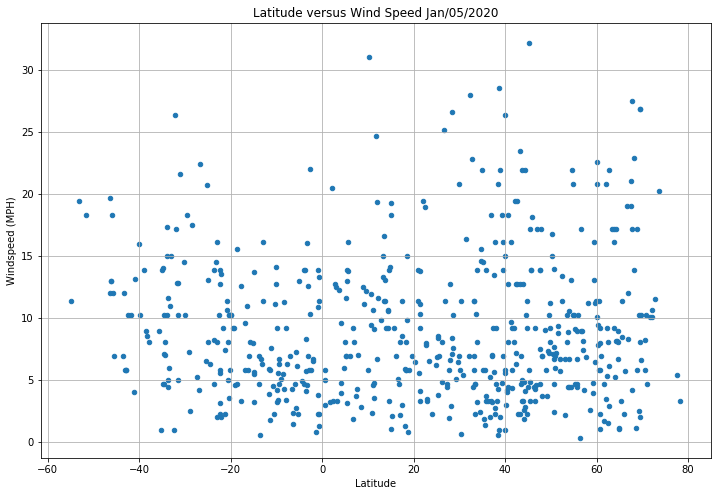

In [20]:
ax = weather_df.plot.scatter(figsize=(12,8), x="lat", y="wind_speed_mph")
ax.set_xlabel("Latitude", fontsize=10)
ax.set_ylabel("Windspeed (MPH)", fontsize=10 )
ax.set_title(f"Latitude versus Wind Speed {date}", fontsize = 12)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.savefig(results_dir + "Lat_versus_Windspeed.png")
plt.show()